## Project 10 Part 1 - Marketing Strategy

### Notebook Content

1. Exploratory Data Analysis
2. Data Preparation

## 1. Exploratory Data Analysis 
---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# (from P8)
import scipy.stats as stats
from feature_engine import imputation as mdi        
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.outliers import OutlierTrimmer

In [ ]:
# (From P9)
from feature_engine.selection import (DropCorrelatedFeatures, SmartCorrelatedSelection, DropConstantFeatures) 
from feature_engine.selection import (DropDuplicateFeatures, SmartCorrelatedSelection, RecursiveFeatureAddition)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("dataset/bank.csv")

In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


There are no null values in the dataset.

    Variables information:
    
    • client data:  
    
        1 - age  
        2 - job: type of job   
        3 - marital: marital status   
        4 - education   
        5 - default: has credit in default?   
        6 - balance: average yearly balance, in euros  
        7 - housing: has housing loan?   
        8 - loan: has personal loan?  
        
    • related with the last contact of the current campaign:  
    
        9 - contact: contact communication type   
        10 - day: last contact day of the month  
        11 - month: last contact month of year  
        12 - duration: last contact duration, in seconds  
        
    • other attributes:  
    
        13 - campaign: number of contacts performed during this campaign and for this client   
        14 - pdays: number of days that passed by after the client was last contacted from a previous campaign  
        15 - previous: number of contacts performed before this campaign and for this client  
        16 - poutcome: outcome of the previous marketing campaign  

        17 - has the client subscribed a term deposit? → Target  



Variable 'duration' will be droped (it is obtained after the call is made → if the target client has never received calls this feature is not that useful, and it also would be leaking information during the model training)

In [7]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Find numerical variables (continuous, discrete, target)

In [6]:
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables:'.format(len(numerical)))
numerical

There are 7 numerical variables:


['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### Find discrete variables

We will select the ones that contain a finite and small number of distinct values from all the numerical ones:

In [7]:
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20:
        print(var, 'values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))


There are 0 discrete variables


That means all our numerical variables are continuous, let's confirm that:

### Continuous variables

In [8]:
continuous = [var for var in numerical if var not in discrete and var not in ['deposit']]

print('There are {} numerical and continuous variables'.format(len(continuous)))
continuous

There are 7 numerical and continuous variables


['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### Find categorical variables 

In [9]:
categorical = [var for var in data.columns if data[var].dtype=='O']  

print('There are {} categorical variables:'.format(len(categorical)))
categorical

There are 10 categorical variables:


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

Categorical variables inspection:

In [10]:
pd.set_option('display.max_colwidth', 0)
data[categorical].agg(['unique']).transpose()

,unique
job,"[admin., technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student]"
marital,"[married, single, divorced]"
education,"[secondary, tertiary, primary, unknown]"
default,"[no, yes]"
housing,"[yes, no]"
loan,"[no, yes]"
contact,"[unknown, cellular, telephone]"
month,"[may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep]"
poutcome,"[unknown, other, failure, success]"
deposit,"[yes, no]"


Variable 'job' shows high cardinality.

Let's resume our features types:

    17 variables → 7 numerical → 7 continuous
                               → 0 discrete
                 
                 → 10 categorical                        

#### Continuous variables distributions

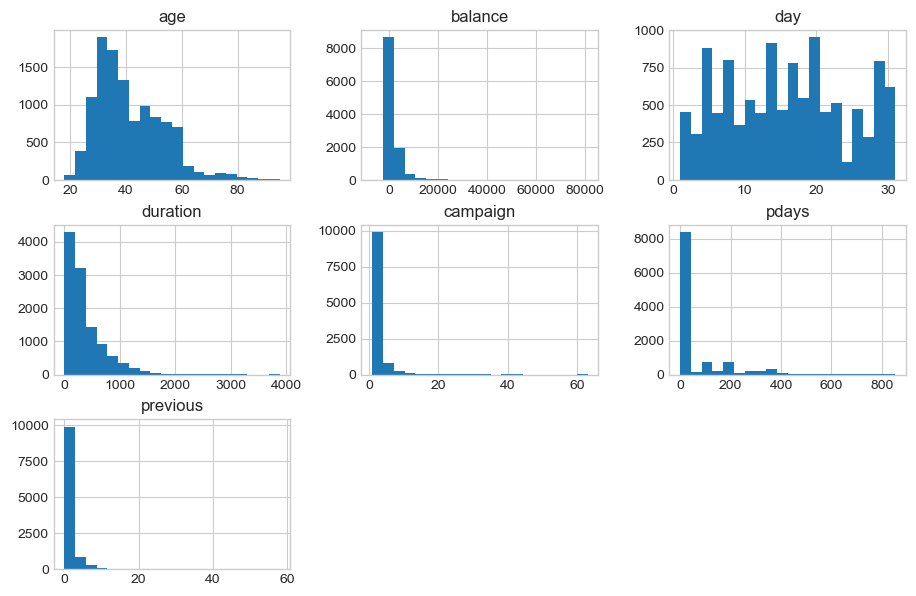

In [41]:
# plt.style.use('seaborn-whitegrid')
data.hist(bins=20, figsize=(11,7))
plt.grid(True)
# data.hist(bins=20, figsize=(12,8), color='#E14906')

plt.show()

Some of the variables show the presence of outliers, especially 'balance'. 

Let's inspect the distribution of our target varible 'deposit':

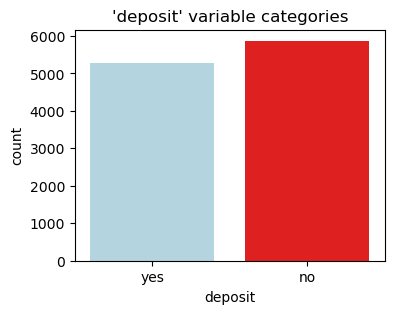

In [28]:
plt.figure(figsize=(4,3))
sns.countplot(x ='deposit', data = data, palette=['lightblue', 'red'])
plt.title('\'deposit\' variable categories', fontsize=12)

plt.show()

The dataset is balanced with respect to our target variable.